# Solving Sudoku using Convolutional Neural Network

In [1]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 1. Load data

In [3]:
def load_sudoku(FILE_PATH):
    quizzes = np.zeros((1000000, 81), np.int32)
    solutions = np.zeros((1000000, 81), np.int32)
    for i, line in enumerate(open(FILE_PATH, 'r').read().splitlines()[1:]):
        quiz, solution = line.split(",")
        for j, q_s in enumerate(zip(quiz, solution)):
            q, s = q_s
            quizzes[i, j] = q
            solutions[i, j] = s
    quizzes = quizzes.reshape((-1, 9, 9))
    solutions = solutions.reshape((-1, 9, 9))
    return quizzes, solutions

def plot_sudoku(sudoku):
    '''
    Helper function to plot sudoku using matplotlib
    '''
    _ = plt.clf()
    fig, ax = plt.subplots(figsize =(5,5))
    
    for i in range(9):
        for j in range(9):
            if sudoku[i][j] > 0:
                _ = ax.text(i+0.5,8.5-j, str(sudoku[i][j]), va='center', ha='center')
    for i in range(3):
        _ = ax.axhline((i+1) * 3, color = "black")
        _ = ax.axvline((i+1) * 3, color = "black")
    _ = ax.set_xlim(0, 9)
    _ = ax.set_ylim(0, 9)
    _ = ax.set_xticks(range(9))
    _ = ax.set_yticks(range(9))
    _ = ax.set_yticklabels([])
    _ = ax.set_xticklabels([])
    _ = ax.grid()
    _ = plt.show()

In [4]:
DATA_PATH = os.path.join("data", "sudoku.csv")

quizzes, solutions = load_sudoku(DATA_PATH)

Sample quiz and solution

<Figure size 432x288 with 0 Axes>

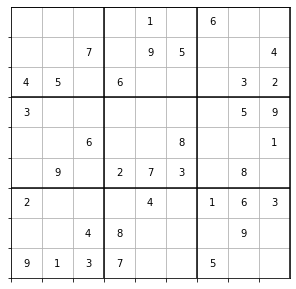

In [5]:
plot_sudoku(quizzes[0])

<Figure size 432x288 with 0 Axes>

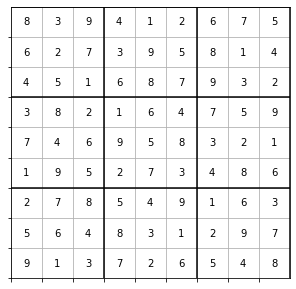

In [6]:
plot_sudoku(solutions[0])

In [7]:
print(quizzes.shape)

(1000000, 9, 9)


## 2. Split data for training, validation, and test set

Ratio for train, validation, and test set = 10:1:1

In [8]:
# separate train and test set
np.random.seed(10)
test_size = 0.1  # test + val size

index = np.arange(0, quizzes.shape[0])
index_train = np.random.choice(index, size=int((1 - test_size) * len(index)), replace=False)
index_test = np.array(list(set(index).difference(set(index_train))))

In [9]:
X_train = quizzes[index_train]
y_train = solutions[index_train]
X_test = quizzes[index_test]
y_test = solutions[index_test]

In [10]:
X_train.shape

(900000, 9, 9)

In [11]:
# separate val and test set
np.random.seed(11)
val_size = 0.5  # test : val size

index = np.arange(0, X_test.shape[0])
index_val = np.random.choice(index, size=int(val_size * len(index)), replace=False)
index_test = np.array(list(set(index).difference(set(index_val))))

In [12]:
X_val = X_test[index_val]
y_val = y_test[index_val]
X_test = X_test[index_test]
y_test = y_test[index_test]

In [13]:
X_val.shape

(50000, 9, 9)

In [14]:
X_test.shape

(50000, 9, 9)

In [15]:
X_train[:2]

array([[[7, 5, 0, 0, 8, 2, 0, 0, 0],
        [3, 0, 0, 0, 6, 7, 9, 0, 1],
        [0, 0, 6, 4, 1, 0, 2, 0, 0],
        [2, 0, 0, 0, 0, 0, 4, 0, 0],
        [0, 0, 0, 3, 0, 5, 7, 0, 8],
        [4, 0, 7, 0, 9, 6, 0, 3, 0],
        [9, 0, 4, 0, 0, 8, 0, 0, 0],
        [6, 0, 0, 0, 0, 9, 5, 0, 2],
        [0, 7, 3, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 5, 0, 0, 2, 0, 0, 1],
        [2, 0, 0, 5, 9, 0, 7, 0, 6],
        [0, 0, 0, 0, 4, 8, 0, 3, 0],
        [6, 0, 0, 0, 0, 3, 0, 0, 9],
        [7, 0, 8, 1, 6, 5, 2, 0, 0],
        [0, 0, 1, 0, 7, 0, 0, 0, 0],
        [0, 6, 2, 9, 0, 0, 3, 0, 0],
        [0, 3, 0, 2, 0, 0, 8, 0, 4],
        [4, 8, 0, 0, 0, 0, 9, 0, 5]]], dtype=int32)

In [16]:
X_val[:2]

array([[[7, 8, 0, 0, 5, 0, 0, 2, 6],
        [1, 0, 3, 6, 0, 0, 0, 9, 7],
        [0, 0, 0, 0, 0, 3, 8, 0, 0],
        [0, 0, 8, 0, 4, 5, 7, 0, 0],
        [2, 4, 0, 0, 0, 0, 0, 3, 0],
        [0, 7, 5, 0, 9, 0, 1, 0, 0],
        [0, 2, 0, 7, 3, 9, 0, 8, 0],
        [0, 9, 0, 0, 0, 0, 0, 0, 0],
        [3, 0, 0, 2, 0, 6, 0, 5, 4]],

       [[6, 0, 0, 0, 0, 0, 0, 0, 7],
        [0, 0, 1, 4, 0, 9, 3, 5, 0],
        [0, 4, 8, 3, 0, 2, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 8, 0, 6],
        [9, 0, 0, 5, 0, 3, 0, 4, 0],
        [7, 3, 2, 0, 4, 0, 9, 1, 0],
        [0, 0, 5, 0, 0, 0, 0, 0, 0],
        [4, 1, 0, 0, 9, 6, 0, 0, 0],
        [0, 0, 0, 8, 5, 1, 2, 0, 0]]], dtype=int32)

In [17]:
X_test[:2]

array([[[6, 0, 0, 1, 2, 0, 3, 8, 4],
        [0, 0, 8, 4, 5, 9, 0, 7, 2],
        [0, 0, 0, 0, 0, 6, 0, 0, 5],
        [0, 0, 0, 2, 6, 4, 0, 3, 0],
        [0, 7, 0, 0, 8, 0, 0, 0, 6],
        [9, 4, 0, 0, 0, 3, 0, 0, 0],
        [3, 1, 0, 0, 0, 0, 0, 5, 0],
        [0, 8, 9, 7, 0, 0, 0, 0, 0],
        [5, 0, 2, 0, 0, 0, 1, 9, 0]],

       [[0, 0, 9, 0, 6, 5, 4, 3, 0],
        [0, 0, 7, 0, 0, 0, 8, 0, 0],
        [6, 0, 0, 1, 0, 8, 0, 2, 0],
        [0, 0, 3, 0, 9, 0, 0, 0, 2],
        [5, 0, 1, 4, 0, 3, 9, 6, 0],
        [8, 0, 4, 0, 0, 0, 1, 0, 0],
        [0, 3, 0, 5, 0, 9, 0, 0, 7],
        [0, 5, 6, 0, 8, 0, 0, 0, 0],
        [0, 7, 0, 2, 4, 0, 0, 9, 0]]], dtype=int32)

In [18]:
y_test[:2]

array([[[6, 9, 5, 1, 2, 7, 3, 8, 4],
        [1, 3, 8, 4, 5, 9, 6, 7, 2],
        [7, 2, 4, 8, 3, 6, 9, 1, 5],
        [8, 5, 1, 2, 6, 4, 7, 3, 9],
        [2, 7, 3, 9, 8, 1, 5, 4, 6],
        [9, 4, 6, 5, 7, 3, 8, 2, 1],
        [3, 1, 7, 6, 9, 2, 4, 5, 8],
        [4, 8, 9, 7, 1, 5, 2, 6, 3],
        [5, 6, 2, 3, 4, 8, 1, 9, 7]],

       [[2, 8, 9, 7, 6, 5, 4, 3, 1],
        [3, 1, 7, 9, 2, 4, 8, 5, 6],
        [6, 4, 5, 1, 3, 8, 7, 2, 9],
        [7, 6, 3, 8, 9, 1, 5, 4, 2],
        [5, 2, 1, 4, 7, 3, 9, 6, 8],
        [8, 9, 4, 6, 5, 2, 1, 7, 3],
        [4, 3, 2, 5, 1, 9, 6, 8, 7],
        [9, 5, 6, 3, 8, 7, 2, 1, 4],
        [1, 7, 8, 2, 4, 6, 3, 9, 5]]], dtype=int32)

## 3. Data preparation

#### Normalization

Neural network converge way faster with normalize input

In [19]:
def normalize_sudoku(sudoku):
    
    # divide by max - min
    norm_sudoku = sudoku / 9
    
    # centered around 0
    norm_sudoku -= np.mean(norm_sudoku)
    
    return norm_sudoku

def normalize_batch(sudokus):
    
    sudokus = sudokus.astype(np.float)
    
    for i in range(sudokus.shape[0]):
        sudokus[i] = normalize_sudoku(sudokus[i])
        
    return sudokus

In [20]:
X_train = normalize_batch(X_train)
X_val = normalize_batch(X_val)
# X_test = normalize_batch(X_test)

#### Add channel dimension

The cnn model takes four dimensional inputs: batch, channel, height, and width. Our inputs only have three dimensions, so we have to reshape the inputs.

In [21]:
X_train = X_train.reshape((-1, 1, 9, 9))
X_val = X_val.reshape((-1, 1, 9, 9))
# X_test = X_test.reshape((-1, 1, 9, 9))

In [22]:
X_train[:2]

array([[[[ 0.54046639,  0.31824417, -0.23731139, -0.23731139,
           0.6515775 , -0.01508916, -0.23731139, -0.23731139,
          -0.23731139],
         [ 0.09602195, -0.23731139, -0.23731139, -0.23731139,
           0.42935528,  0.54046639,  0.76268861, -0.23731139,
          -0.12620027],
         [-0.23731139, -0.23731139,  0.42935528,  0.20713306,
          -0.12620027, -0.23731139, -0.01508916, -0.23731139,
          -0.23731139],
         [-0.01508916, -0.23731139, -0.23731139, -0.23731139,
          -0.23731139, -0.23731139,  0.20713306, -0.23731139,
          -0.23731139],
         [-0.23731139, -0.23731139, -0.23731139,  0.09602195,
          -0.23731139,  0.31824417,  0.54046639, -0.23731139,
           0.6515775 ],
         [ 0.20713306, -0.23731139,  0.54046639, -0.23731139,
           0.76268861,  0.42935528, -0.23731139,  0.09602195,
          -0.23731139],
         [ 0.76268861, -0.23731139,  0.20713306, -0.23731139,
          -0.23731139,  0.6515775 , -0.23731139, -

In [23]:
X_train.shape

(900000, 1, 9, 9)

#### Reshape target variables

Also since each cell is a number between 1 to 9, we have to subtract the target by 1 and make it from 0 to 8

In [24]:
# y_train = y_train.reshape((y_train.shape[0], -1))
# y_val = y_val.reshape((y_val.shape[0], -1))
# y_test = y_test.reshape((y_test.shape[0], -1))

y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

In [25]:
y_test[:2]

array([[[5, 8, 4, 0, 1, 6, 2, 7, 3],
        [0, 2, 7, 3, 4, 8, 5, 6, 1],
        [6, 1, 3, 7, 2, 5, 8, 0, 4],
        [7, 4, 0, 1, 5, 3, 6, 2, 8],
        [1, 6, 2, 8, 7, 0, 4, 3, 5],
        [8, 3, 5, 4, 6, 2, 7, 1, 0],
        [2, 0, 6, 5, 8, 1, 3, 4, 7],
        [3, 7, 8, 6, 0, 4, 1, 5, 2],
        [4, 5, 1, 2, 3, 7, 0, 8, 6]],

       [[1, 7, 8, 6, 5, 4, 3, 2, 0],
        [2, 0, 6, 8, 1, 3, 7, 4, 5],
        [5, 3, 4, 0, 2, 7, 6, 1, 8],
        [6, 5, 2, 7, 8, 0, 4, 3, 1],
        [4, 1, 0, 3, 6, 2, 8, 5, 7],
        [7, 8, 3, 5, 4, 1, 0, 6, 2],
        [3, 2, 1, 4, 0, 8, 5, 7, 6],
        [8, 4, 5, 2, 7, 6, 1, 0, 3],
        [0, 6, 7, 1, 3, 5, 2, 8, 4]]], dtype=int32)

In [26]:
y_test.shape

(50000, 9, 9)

#### Convert to DataLoader

In [27]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def create_dataloader(X, y, batch_size=128, randomize=False):
    '''
    Function to create dataloader for batch training
    '''
    data = TensorDataset(torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.long))
    
    if randomize:
        sampler = RandomSampler(data)
    else:
        sampler = SequentialSampler(data)
    loader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return loader

In [28]:
train_loader = create_dataloader(X_train, y_train, batch_size=256)
val_loader = create_dataloader(X_val, y_val, batch_size=256)
# test_loader = create_dataloader(X_test, y_test, batch_size=256)

## 4. Define the model

In [29]:
import torch.nn as nn
import torch.nn.functional as F


class SudokuCNN(nn.Module):
    '''
    Convolution + Batch Normalization + Relu
    '''
    
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        
        # Get the padding size
        if type(kernel_size) == tuple:
            pad_height = kernel_size[0] // 2
            pad_width = kernel_size[1] // 2
        else:
            pad_height = kernel_size // 2
            pad_width = kernel_size // 2
        
        self.padding = nn.ReflectionPad2d((pad_width, pad_width, pad_height, pad_height))
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        
        # Apply reflection padding
        x = self.padding(x)
        
        # Convolution
        x = self.conv(x)
        
        # Batch Normalization
        x = self.batch_norm(x)
        
        # Relu
        x = F.relu(x)
        
        return x

class SudokuModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.first_layer = SudokuCNN(in_channels=1, out_channels=1024, kernel_size=3)
        self.middle_layer = nn.Sequential(
            SudokuCNN(in_channels=1024, out_channels=1024, kernel_size=(3,3)),
            SudokuCNN(in_channels=1024, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=512, kernel_size=(3,3)),
            SudokuCNN(in_channels=512, out_channels=256, kernel_size=(3,3)),
            SudokuCNN(in_channels=256, out_channels=128, kernel_size=(3,3)),
            SudokuCNN(in_channels=128, out_channels=128, kernel_size=(3,3))
        )
        self.last_layer = nn.Conv2d(in_channels=128, out_channels=9, kernel_size=(1,1))
        
    def forward(self, x):
        
        # First layer
        x = self.first_layer(x.float())
        
        # Middle layer
        x = self.middle_layer(x)
        
        # Last layer
        x = self.last_layer(x)
        
        return x

In [30]:
model = SudokuModel()

In [31]:
print(model)

SudokuModel(
  (first_layer): SudokuCNN(
    (padding): ReflectionPad2d((1, 1, 1, 1))
    (conv): Conv2d(1, 1024, kernel_size=(3, 3), stride=(1, 1))
    (batch_norm): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (middle_layer): Sequential(
    (0): SudokuCNN(
      (padding): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SudokuCNN(
      (padding): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): SudokuCNN(
      (padding): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

## 5. Set up optimizer

In [32]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 6. Set up loss function and sudoku accuracy

#### TODO: Find better loss function

The loss function must use pytorch operation since it will automatically calculates the derrivatives.

$$Loss = \frac{1}{n}\sum_{j=1}^{n}\sum_{i = 1}^{81}(y_{i} - \hat{y}_{i})^2 $$

In [33]:
# def compute_loss(output, target):
#     loss = torch.mean(torch.sum((output - target)**2, dim=1))
#     return loss

In [34]:
criterion = nn.CrossEntropyLoss()

We can define the sudoku accuracy as the number of correct answers

In [35]:
def sudoku_accuracy(output, target):
    
    return torch.mean((torch.sum(torch.argmax(output, dim=1) == (target + 1), dim=(1,2)) == 81).float()).item()

## 7. Train the model

In [36]:
def save_model(model, file_name):
    MODEL_PATH = os.path.join(".", "model")
    
    # if directory doesn't exists, create new one
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    file_name = os.path.join(MODEL_PATH, file_name)
    torch.save(model.state_dict(), file_name)
    
def load_model(model, file_name):
    FILE_PATH = os.path.join(os.path.join(".", "model"), file_name)
    
    # if file exists
    if os.path.exists(FILE_PATH):
        model.load_state_dict(torch.load(FILE_PATH, map_location=torch.device('cpu')))
        
    return model
    

def train(model, num_epochs, gpu=True, save=True, load=True, file_name="model.pth"):
    
    num_batch = (X_train.shape[0] // 128) + 1
    
    if gpu:
        model.to(device)
        
    if load:
        model = load_model(model, file_name)  
    
    train_loss_histories = []
    val_loss_histories = []
    accuracy_histories = []
    
    for epoch in range(num_epochs):

        print()
        print(f"======= Epoch {epoch + 1} / {num_epochs} ======")
        print('Training...')

        train_loss = 0
        n_step = 0

        for step, batch in enumerate(train_loader, 0):
            
            print(f"Train batch {n_step+1}/{num_batch}", end='\r')
            
            batch_data, batch_labels = batch
            
            if gpu:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            # clear previously calculated gradients
            model.zero_grad()

            # perform a forward pass
            output = model(batch_data)

            # compute loss
            loss = criterion(output, batch_labels)
            train_loss += loss.item()

            # perform backward pass
            loss.backward()

            # step
            optimizer.step()

            # increment step
            n_step += 1

        print(f"Training loss: {train_loss / n_step}")
        train_loss_histories.append(train_loss/n_step)

        print("Validation...")

        # variables for tracking
        val_loss = 0
        accuracy = 0
        n_step = 0

        for batch in val_loader:

            batch_data, batch_labels = batch
            
            if gpu:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            # tell pytorch to not compute the gradient
            with torch.no_grad():

                # perform a forward pass
                output = model(batch_data)

            # compute loss
            val_loss += criterion(output, batch_labels).item()

            # compute accuracy
            accuracy += sudoku_accuracy(output, batch_data, batch_labels)

            # increment step
            n_step += 1

        print(f"Validation loss: {val_loss / n_step}")
        val_loss_histories.append(val_loss / n_step)
        
        print(f"Sudoku accuracy: {accuracy / n_step}")
        accuracy_histories.append(accuracy / n_step)
        
        
        
        #########################
        #      Saving model     #
        #########################

        if save:
            save_model(model, file_name)

In [ ]:
# num_epochs = 20
# train(model, num_epochs, gpu=False, save=True, load=True, file_name="model2.pth")

I run this program using aws ec2 g4dn.xlarge for 20 epochs, it took me approximately 12 hours..

##### Result:
train_loss = 

val_loss = 

In [ ]:
model = load_model(model, file_name="model2.pth")

## 8. Calculate test accuracy

In [38]:
def sudoku_accuracy(batch_data, batch_label):
    
    if len(batch_data.shape) == 3:
        batch_data = batch_data.reshape((-1, 1, 9, 9))
    
    batch_data_copy = batch_data.copy()
    
    # normalize batch
    batch_data_copy = normalize_batch(batch_data_copy)
    
    # prediction, add 1
    output = torch.argmax(model(torch.tensor(batch_data_copy, dtype=torch.float)), dim=1) + 1

    # check if it is equals to the true label
    result = output.numpy() == (batch_label + 1)
    
    # calculate accuracy based on which cell has 0 value on the data
    return np.mean(result.flatten()[batch_data.flatten() == 0])

In [39]:
X_test.shape

(50000, 9, 9)

In [ ]:
acc = sudoku_accuracy(X_test, y_test)
print(f"Test accuracy: {acc}")

## 9. Deploy the model

In [40]:
def solve(sudoku, model=model):

    sudoku_answer = sudoku.copy()
    
    # normalize sudoku
    sudoku = normalize_sudoku(sudoku)
    
    # convert to tensor
    sudoku = torch.tensor(sudoku, dtype=torch.float)
    
    # add dimension to (1, 1, 9, 9)
    sudoku = torch.unsqueeze(sudoku, 0)
    sudoku = torch.unsqueeze(sudoku, 0)
    
    # get the prediction
    output = model(sudoku)
    
    # get the output
    output = torch.argmax(output, dim=1)[0].numpy() + 1
    
    # put answers to cell which has value of 0
    for i in range(9):
        for j in range(9):
            if sudoku_answer[i, j] == 0:
                sudoku_answer[i, j] = output[i, j]
                
    return sudoku_answer

### Sample result:

Quiz: 


<Figure size 432x288 with 0 Axes>

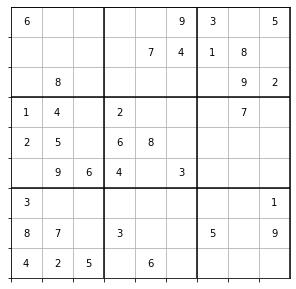

In [44]:
print("Quiz: ")
plot_sudoku(X_test[0])

Prediction: 


<Figure size 432x288 with 0 Axes>

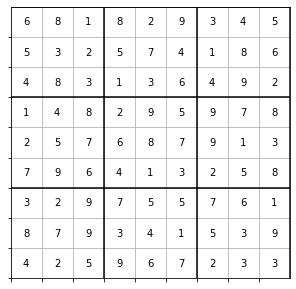

In [45]:
print("Prediction: ")
plot_sudoku(solve(X_test[0]))

True value: 


<Figure size 432x288 with 0 Axes>

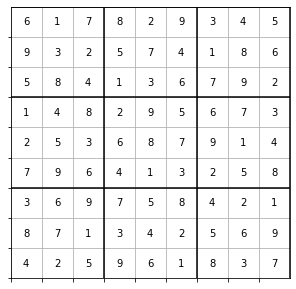

In [46]:
print("True value: ")
plot_sudoku(y_test[0] + 1)

## 10. Conclusion

While the accuracy of solving sudoku is quite high, the number of perfect answer is still 0. It's always better to use other method such as CSP or backtracking